# Simulated Based Inference of  BOLD by Generic Hopf model 

### Set up

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
from numba import jit
import scipy as scp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer


from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, DirectPosterior, MCMCPosterior, VIPosterior

from sbi.analysis import pairplot
import sbi.utils as utils

In [3]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [4]:
from FCD import extract_FCD

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on sbi: v0.18.0


In [9]:
sns.set(style="white")
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [10]:
cwd = os.getcwd()
cwd

'/data/SBI/GenericHopf_SBI'

In [11]:
import warnings
np.seterr(all = 'ignore')
warnings.filterwarnings("ignore")

In [12]:
Res_dir='Res_SBI_BNM_GenericHopf_InferG_SpectralEmbedding_savesim10k_v18'

# Load the Human Connectome

In [13]:
weights= np.loadtxt(cwd+ '/ExperimentalData/hcp_001/weights.txt')

In [14]:
weights.shape, weights.min(), weights.max()

((84, 84), 0.0, 8706.0)

In [15]:
nn=weights.shape[0]
print  ('The number of regions  is: ', nn)

The number of regions  is:  84


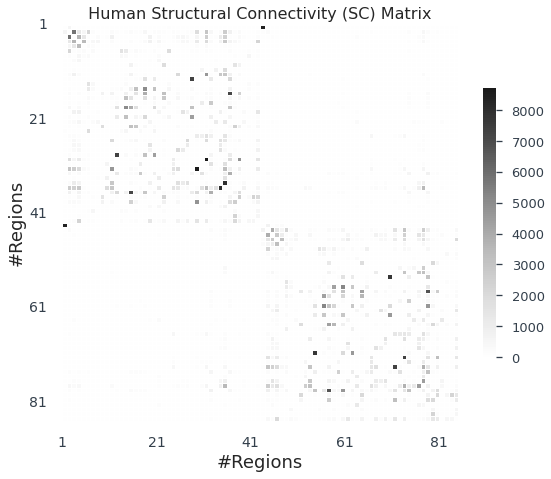

In [16]:
plt.figure(figsize=(8, 8))
mask = np.zeros_like(weights, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap='RdGy'
sns.heatmap(weights, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(' Human Structural Connectivity (SC) Matrix ',fontsize=16)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
plt.yticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
#plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix.eps"), doi=800)
plt.show()

In [17]:
con = weights/np.max(weights)

In [18]:
con.shape, con.min(), con.max()

((84, 84), 0.0, 1.0)

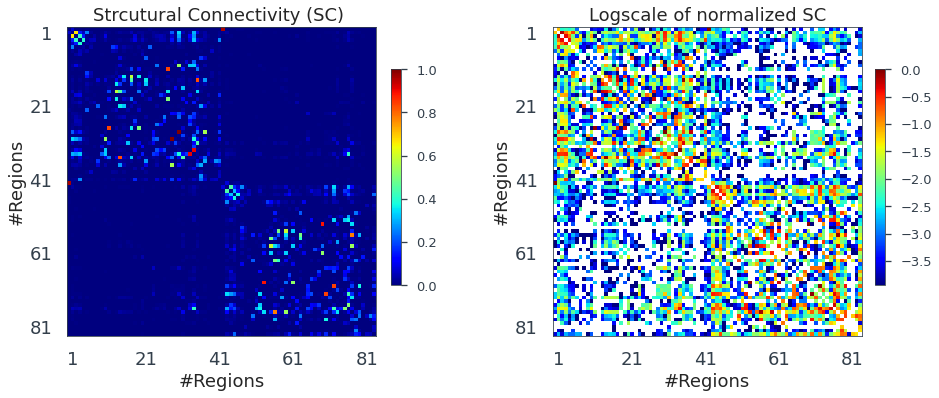

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
norm = colors.LogNorm(1e-7, con.max())
i=axs[0].imshow(con,cmap=cm.jet)
colorbar_ax = fig.add_axes([0.45, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[0].set_title('Strcutural Connectivity (SC) ', fontsize=18.0)
axs[0].set_ylabel('#Regions', fontsize=18.0)
axs[0].set_xlabel('#Regions', fontsize=18.0)
axs[0].tick_params(labelsize=18)
axs[0].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[0].yaxis.set_ticks(np.r_[1:nn+1][::20])

i=axs[1].imshow(np.log10(con),cmap=cm.jet)
colorbar_ax = fig.add_axes([.93, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[1].set_title('Logscale of normalized SC', fontsize=18.0)
axs[1].set_ylabel('#Regions', fontsize=18.0)
axs[1].set_xlabel('#Regions', fontsize=18.0)
axs[1].tick_params(labelsize=18)
axs[1].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[1].yaxis.set_ticks(np.r_[1:nn+1][::20])

fig.tight_layout(pad=2)

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_Normalized.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_Normalized.eps"), doi=800)
plt.show()

### constants

In [20]:
eta_c=0       
delta_eta=.5                  
prior_std =1.0
sd_thr=0.5

# whole-brain network simulation

In [21]:
from GenericHopfModel import GenericHopfBOLD

In [22]:
from GenericHopfModel_features import calculate_summary_statistics

In [23]:
@jit(nopython=False)
def GenericHopf_simulator_wrapper(params):
    
    params = np.asarray(params)
    
    ## fixed values: simulation time lenght (T), the time step (dt), the array of time points (ts),  
    ##  noise level (sigma), time step for BalloonWindkessel, downsampling (ds). 
    
    Tmax = 120.0
    dt=0.001
    ts = np.arange(0, Tmax + dt, dt)
    sigma=1e-1
    dt_bold=0.001
    ds=180


    ## initial conditions
    x_init=0
    y_init=0
    init_conditions = np.array([x_init, y_init])

    ##param : global coupling parameter (G)
    params_G=params[0]
    
    nn=SC.shape[0]
    
    Simulated_BOLD = GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, params_G, SC,  dt, dt_bold, Tmax, ds)

    return Simulated_BOLD 

### some simulations for  sanity check


In [24]:
Sim_dir='data_input_SaveSims_GenericHopf_FixedRandFreq'

In [25]:
eta_true=np.load(os.path.join(cwd+'/'+Sim_dir, 'eta_true.npy'))
omega_true=np.load(os.path.join(cwd+'/'+Sim_dir, 'omega_true.npy'))

In [26]:
Tmax = 120.0
dt=0.001
ts = np.arange(0, Tmax + dt, dt)
sigma=1e-1
dt_bold=0.001
ds=180

In [27]:
nt=ts.shape[0]
nt_bold=int(nt/ds)
nt, nt_bold

(120001, 666)

In [28]:
SC=con
nn=SC.shape[0]
nn

84

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


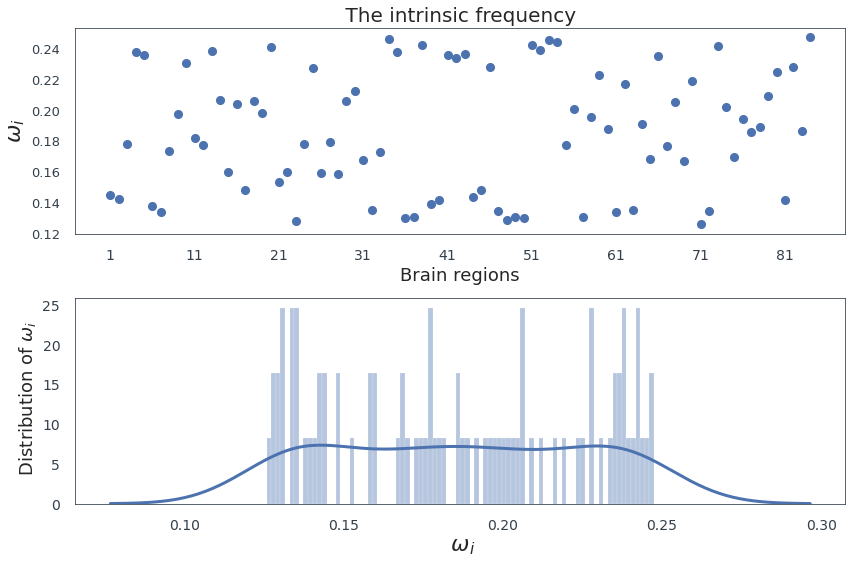

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(omega_true, 'bo')
plt.title(' The intrinsic frequency ',fontsize=20)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\omega_i$',fontsize=22)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(212)
prior_plot=sns.distplot(omega_true, bins=84,hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.ylabel(' Distribution of $\omega_i$',fontsize=18)
plt.xlabel(' $\omega_i$',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


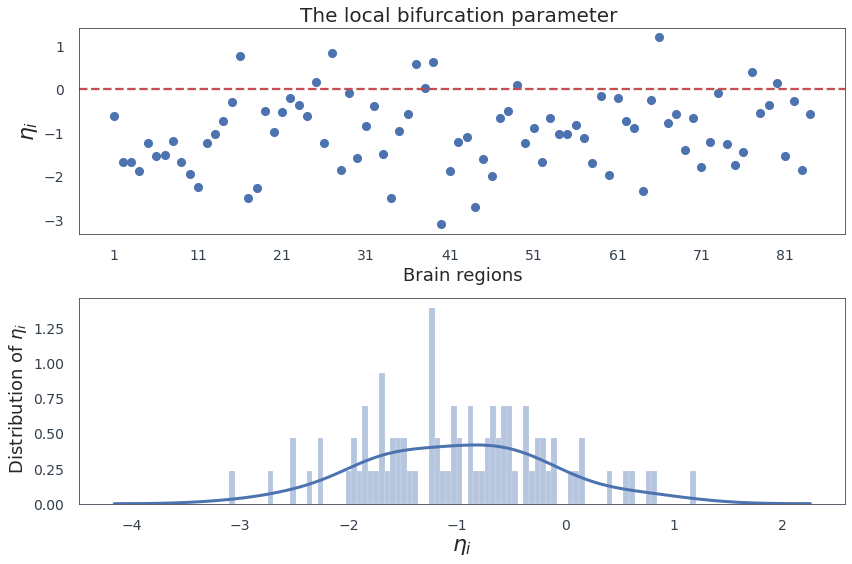

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(211)

plt.plot(eta_true, 'bo')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('The local bifurcation parameter ',fontsize=20)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\eta_i$',fontsize=22)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
#plt.hist(eta_true, bins=84);
prior_plot=sns.distplot(eta_true, bins=84, hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.ylabel(' Distribution of $\eta_i$',fontsize=18)
plt.xlabel('$\eta_i$',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.eps"), doi=800)
plt.show()

In [31]:
## initial conditions
x_init=0
y_init=0
init_conditions = np.array([x_init, y_init])

In [32]:
G_true=0.25

In [33]:
# stacking all the params
params_true = np.hstack([G_true])
params_true.shape

(1,)

### Run Sanity check with JIT

In [34]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_bold, Tmax, ds)

print(" one simulation (sec) takes:" , (time.time() - start_time))

 one simulation (sec) takes: 5.353006839752197


In [35]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_bold, Tmax, ds)

print(" one JIT simulation  (sec) takes:" , (time.time() - start_time))

 one JIT simulation  (sec) takes: 3.681248426437378


In [36]:
BOLD_.shape

(56028,)

In [37]:
BOLD_sanity=BOLD_.reshape(nn, int(BOLD_.shape[0]/nn))

BOLD_sanity.shape

(84, 667)

In [38]:
np.save(os.path.join(Res_dir, 'Sim_BOLD_sanity_GenericHopf_G'+str(G_true)+'.npy') , BOLD_sanity)

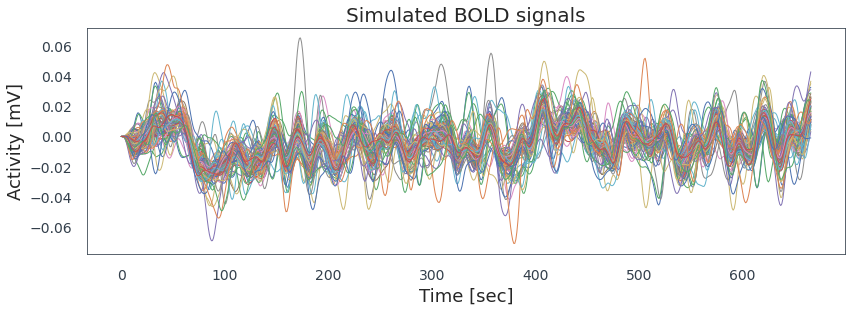

In [39]:
plt.figure(figsize=(12,4.5))
plt.plot(BOLD_sanity.T, lw=1)
plt.title("Simulated BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.eps"), doi=800)
plt.show()

In [40]:
FCcorr=np.corrcoef(BOLD_sanity)
FCcorr.shape

(84, 84)

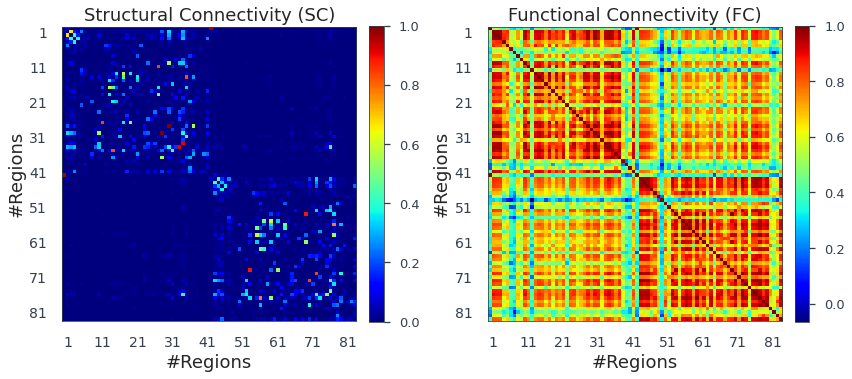

In [41]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Structural Connectivity (SC)', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Functional Connectivity (FC)', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SCFC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SCFC.eps"), doi=800)
plt.show()

In [42]:
wwidth=30
maxNwindows=200
olap=0.94

In [43]:
FCDcorr,Pcorr,shift=extract_FCD(BOLD_sanity,wwidth,maxNwindows,olap,mode='corr')
FCDcorr.shape

(207, 207)

In [44]:
FCDcorr.var(), FCDcorr.sum(), 

(0.03304998410095351, 15751.957704529905)

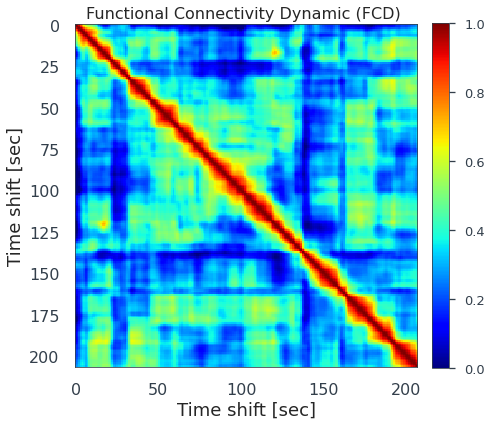

In [45]:
plt.figure(figsize=(7, 7))
plt.imshow(FCDcorr, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Functional Connectivity Dynamic (FCD) ', fontsize=16)
plt.ylabel('Time shift [sec]', fontsize=18.0)
plt.xlabel('Time shift [sec]', fontsize=18.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.eps"), doi=800)
plt.show()

In [46]:
from sklearn import manifold

In [47]:
X=BOLD_sanity
X.shape

(84, 667)

In [48]:
n_neighbors = 10
n_samples = int(X.shape[1])
n_components=2

In [49]:
X_manifold = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(X.T).T
X_manifold.shape

(2, 667)

In [50]:
np.mean(X_manifold, axis=1), np.var(X_manifold, axis=1)

(array([-5.17788106e-06, -2.23908666e-06]), array([0.00016632, 0.0001665 ]))

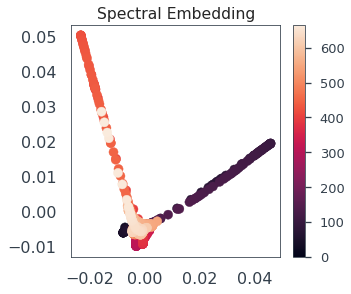

In [51]:
plt.figure(figsize=(5, 4))
plt.scatter(X_manifold[0], X_manifold[1], c=np.r_[0:X_manifold.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Spectral Embedding')
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SpectralEmbedding.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SpectralEmbedding.eps"), doi=800)
plt.show()

### 2. Prior over model parameters

Here we provide a plausible ranges for the parameters that we aim to infer, by placing a uniform prior on them.

In [52]:
prior_min_G=0.0*np.ones(1)

prior_max_G=1.0*np.ones(1)

In [53]:
prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [54]:
prior_min.shape, prior_max.shape

((1,), (1,))

In [55]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [56]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 1


### Load simulations

In [57]:
num_sim=10000

In [58]:
mysavepath = os.path.join(cwd+'/'+Sim_dir , 'data_input_SaveSims_GenericHopf_FixedRandFreq_'+str(num_sim)+'sims/simulated_theta_x_GenericHopf_'+str(num_sim)+'sims.npz')
mysavepath

'/data/SBI/GenericHopf_SBI/data_input_SaveSims_GenericHopf_FixedRandFreq/data_input_SaveSims_GenericHopf_FixedRandFreq_10000sims/simulated_theta_x_GenericHopf_10000sims.npz'

In [59]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)

### Load simulations and calculate features

Now we load the simulator output to calculate the data features

In [60]:
loaded_simulations=np.load(mysavepath)

In [61]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [62]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (10000, 1)
data shape: (10000, 56028)


In [63]:
if np.isfinite(np.sum(x_sim[0,:]))==True:
    _=calculate_summary_statistics(x_sim[0,:], nn, features=['Spectral_Embedding'])
    _.shape

num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 1437


In [64]:
theta_features=np.zeros((num_sim,num_params))
x_features=np.zeros((num_sim,num_features))

In [65]:
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

theta shape: (10000, 1)
data frature shape: (10000, 1437)


In [66]:
start_time = time.time()

i = 0
while i < 2*num_sim:
       if np.isfinite(np.sum(x_sim))==True:
              theta_features[i,:]=theta_sim[i,:] 
              x_features[i,:]=calculate_summary_statistics(x_sim[i,:], nn, features=['Spectral_Embedding'])
       if i == num_sim-1:
           break
       i += 1
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))    

------------------------------------------------------------
--- Calculating features took: 3317.9434807300568 seconds ---


In [67]:
np.isnan(np.sum(x_features))

False

In [68]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [69]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 1])
data feature shape: torch.Size([10000, 1437])


In [70]:
from report_metrics import z_score, shrinkage

In [71]:
b=0.
a=1.
prior_std =np.sqrt((1/12)*(b-a)**2)

In [72]:
def plot_zscore_shrinkage(nodes, param_true, param_est_mu, param_est_std, prior_std):
    z_score_param=z_score(param_true, param_est_mu, param_est_std)
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], param_est_std), z_score_param ,s=120, c='blue')
    plt.xlabel("Posterior shrinkage", fontsize=24)
    plt.ylabel("Posterior z-score", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.axis((-.1,1.1,-0.5,18))
    args = {'ha': 'center', 'va': 'center'}
    plt.text(0.20, 2.5, "Poorly\nidentified", **args, color='r', fontsize=12)
    plt.text(0.20, 15.1, "Prior-\nposterior\nconflict", **args, color='r', fontsize=12)
    plt.text(0.85, 3., "Ideal fit", **args, color='r', fontsize=12)
    plt.text(0.85, 15.1, "Overfit", **args, color='r', fontsize=12)

### 3. Inference

In [73]:
inference = SNPE(prior, density_estimator='maf', device='cpu')

In [74]:
start_time = time.time()

posterior_estimator = inference.append_simulations(theta, x).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 24 epochs.------------------------------------------------------------
---training took:  41.07832670211792 seconds ---


### Observed data set I (optimal G)

In [75]:
G_true=0.25

In [76]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.650148868560791


In [77]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['Spectral_Embedding'])

In [78]:
obs_bold_features.max()

4.690853703237748

In [79]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (1437,))

In [80]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

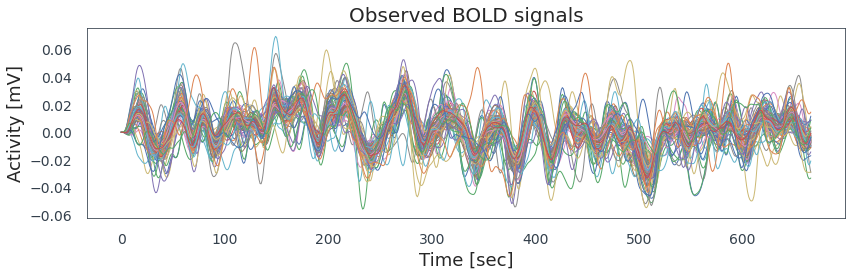

In [81]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs1.eps"), doi=800)
plt.show()

In [82]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [83]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

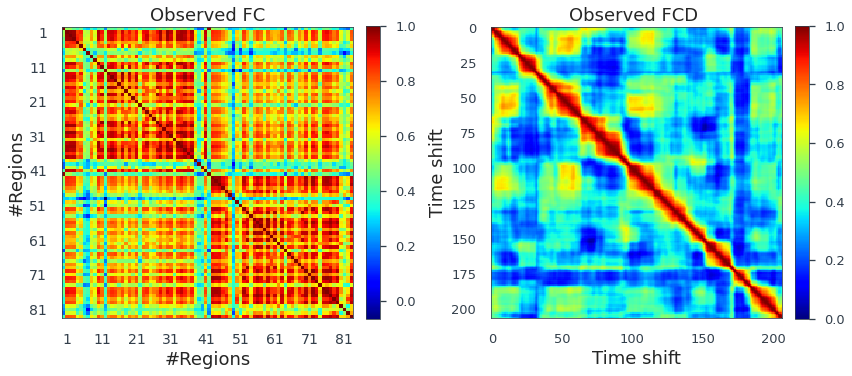

In [84]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_FC_FCD_obs1.eps"), doi=800)
plt.show()

In [85]:
X_manifold_obs = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_obs.T).T
X_manifold_obs.shape

(2, 667)

In [86]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([-6.06186284e-06, -1.85471934e-05]), array([0.00016585, 0.0001675 ]))

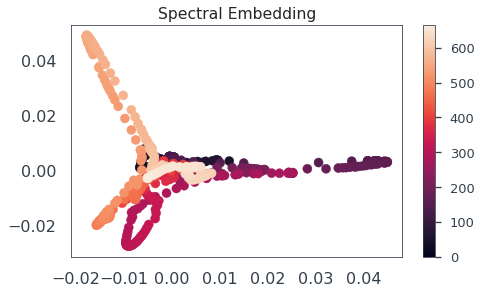

In [87]:
plt.figure(figsize=(7, 4))
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Spectral Embedding')
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs1.eps"), doi=800)
plt.show()

### Posterior of G for  data set I

In [88]:
labels_params = [r'$G$']

In [89]:
num_samples=2000

In [90]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [91]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.20671486854553223


In [92]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs1.npy') , posterior_samples)

In [93]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [94]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.11616469],
       [0.28534011]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


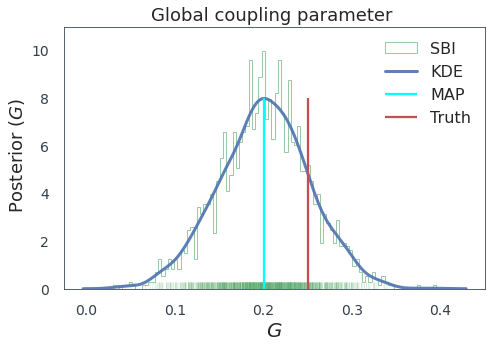

In [95]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')


x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.eps"), doi=800)
plt.show()

In [96]:
G_true, G_posterior.mean(), G_posterior.var()

(0.25, 0.20110816, 0.0026061586)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


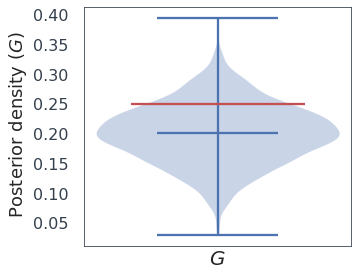

In [97]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.eps"), doi=800)
plt.show()

In [98]:
param_true=G_true
param_est_mu=G_posterior.mean()
param_est_std=G_posterior.std()
nodes=np.r_[0:num_params]

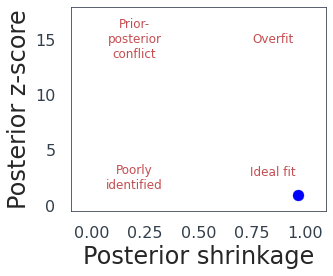

In [99]:
plt.figure(figsize=(5,4))
plot_zscore_shrinkage(nodes, param_true, param_est_mu, param_est_std, prior_std)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs1.eps"), doi=800)
plt.show()

In [100]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.11616469],
       [0.28534011]])

In [101]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [102]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [103]:
np.save(os.path.join(Res_dir, 'BOLD_obs1.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit1.npy') , BOLD_fit)

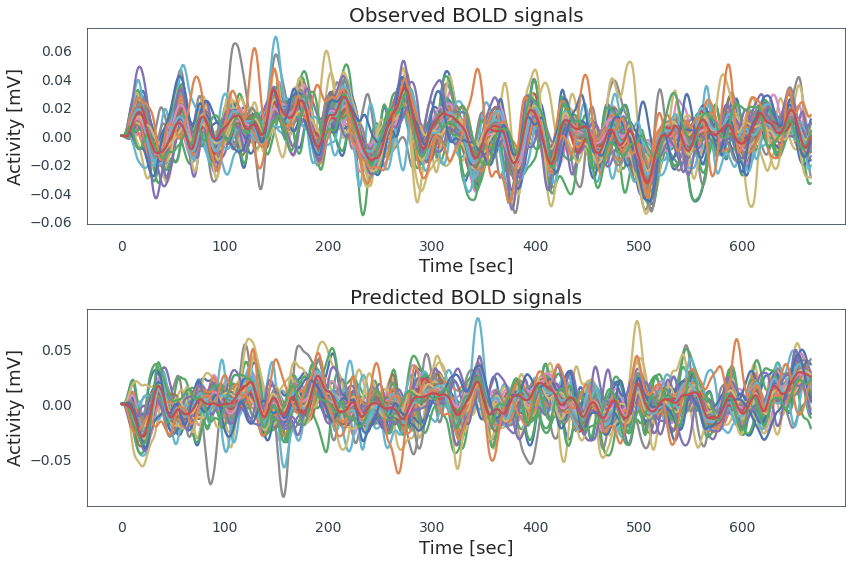

In [104]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.eps"), doi=800)
plt.show()

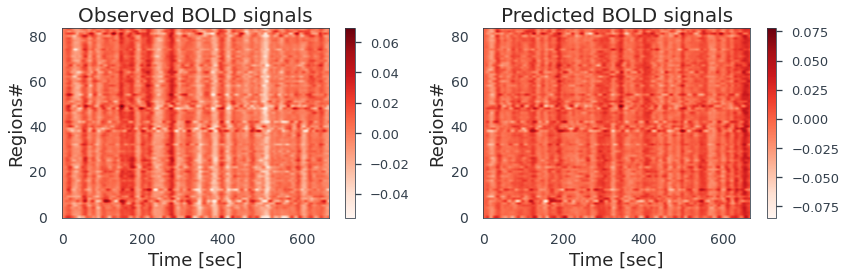

In [105]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.eps"), doi=800)
plt.show()

In [106]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

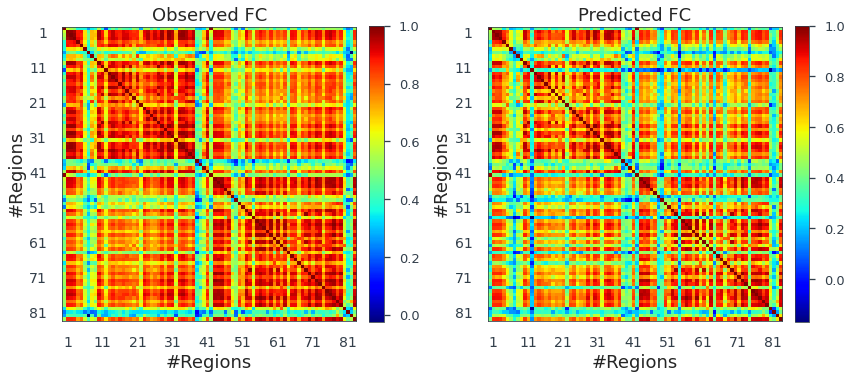

In [107]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.eps"), doi=800)
plt.show()

In [108]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

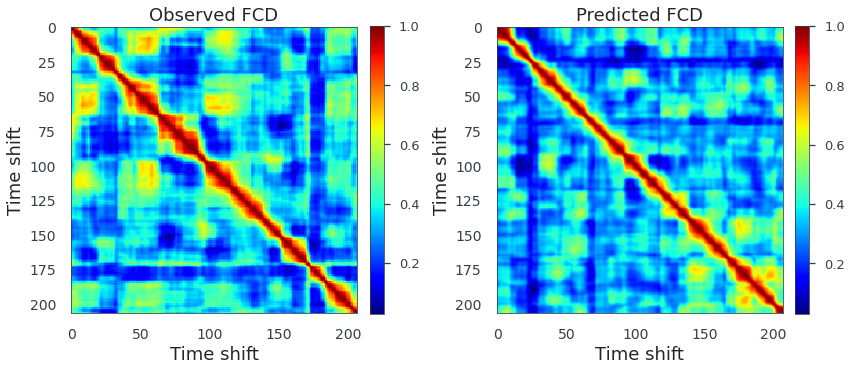

In [109]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


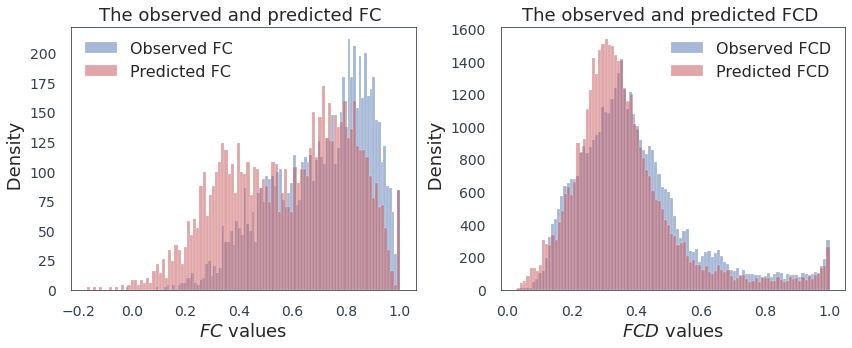

In [110]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.eps"), doi=800)
plt.show()

In [111]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(59.37791053616965, 49.35065011597347)

In [112]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(202.76347093980306, 187.16371366358058)

In [113]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [114]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(3222.8535555160724, 485.93110043043083)

In [115]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

446.2184086238286

In [116]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.030582311647842222

In [117]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.06216794456439799

In [118]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.09759854372330745, pvalue=4.3768486102582814e-178)

In [119]:
X_manifold_fit = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_fit.T).T
X_manifold_fit.shape

(2, 667)

In [120]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([-6.06186284e-06, -1.85471934e-05]), array([0.00016585, 0.0001675 ]))

In [121]:
np.mean(X_manifold_fit, axis=1), np.var(X_manifold_fit, axis=1)

(array([-1.02837930e-05,  8.89719238e-06]), array([0.00016556, 0.00016657]))

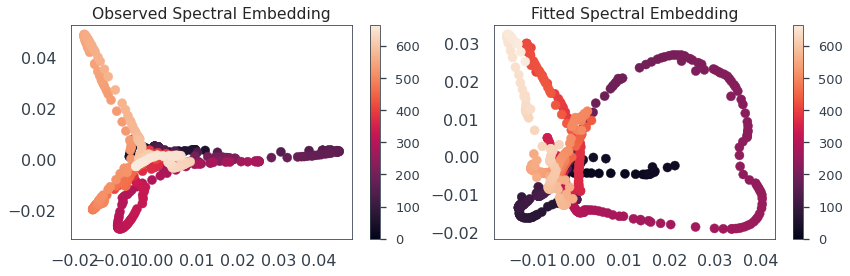

In [122]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Observed Spectral Embedding')

plt.subplot(122)
plt.scatter(X_manifold_fit[0], X_manifold_fit[1], c=np.r_[0:X_manifold_fit.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Fitted Spectral Embedding')

plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs1.eps"), doi=800)

plt.show()

# Another data set

### Observed data set II (low G)

In [123]:
G_true=0.1

In [124]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.8227498531341553


In [125]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['Spectral_Embedding'])

In [126]:
obs_bold_features.max()

4.076477739355246

In [127]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (1437,))

In [128]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

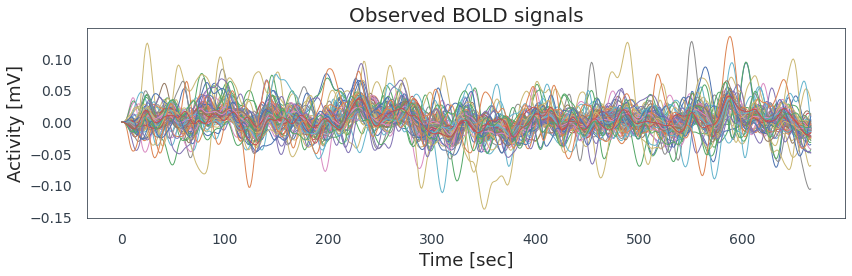

In [129]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.eps"), doi=800)
plt.show()

In [130]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [131]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

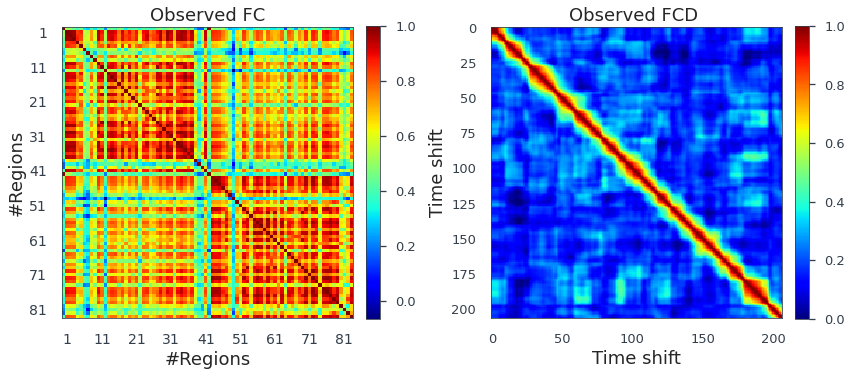

In [132]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs2.eps"), doi=800)
plt.show()

In [133]:
X_manifold_obs = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_obs.T).T
X_manifold_obs.shape

(2, 667)

In [134]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([5.99053734e-06, 2.54507302e-06]), array([0.00016668, 0.00016659]))

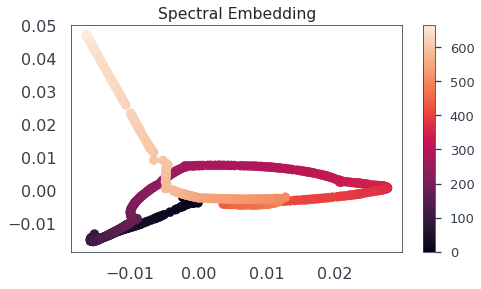

In [135]:
plt.figure(figsize=(7, 4))
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Spectral Embedding')
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs2.eps"), doi=800)
plt.show()

### Posterior of G for  data set II

In [136]:
labels_params = [r'$G$']

In [137]:
num_samples=2000

In [138]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [139]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.05025768280029297


In [140]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs2.npy') , posterior_samples)

In [141]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [142]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.17186281],
       [0.4470139 ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


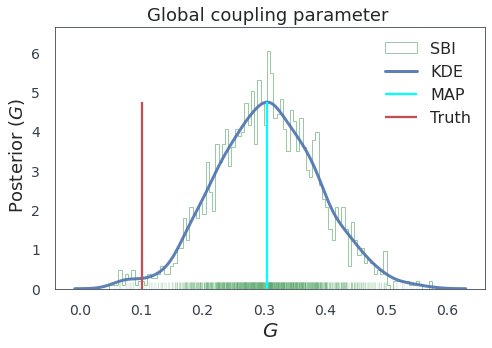

In [143]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.eps"), doi=800)
plt.show()

In [144]:
G_true, G_posterior.mean(), G_posterior.var()

(0.1, 0.30506635, 0.0071511646)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


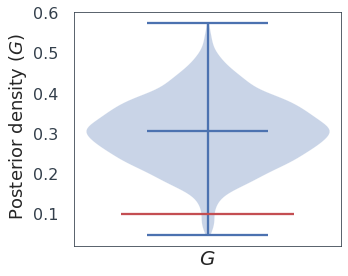

In [145]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.eps"), doi=800)
plt.show()

In [146]:
param_true=G_true
param_est_mu=G_posterior.mean()
param_est_std=G_posterior.std()
nodes=np.r_[0:num_params]

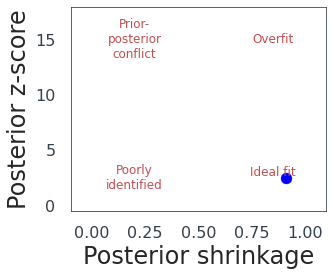

In [147]:
plt.figure(figsize=(5,4))
plot_zscore_shrinkage(nodes, param_true, param_est_mu, param_est_std, prior_std)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs2.eps"), doi=800)
plt.show()

In [148]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.17186281],
       [0.4470139 ]])

In [149]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [150]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [151]:
np.save(os.path.join(Res_dir, 'BOLD_obs2.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit2.npy') , BOLD_fit)

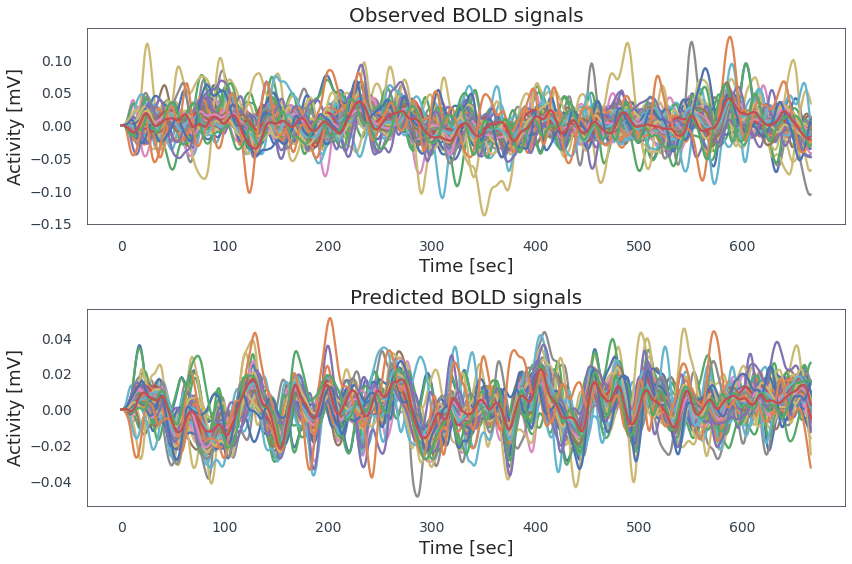

In [152]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.eps"), doi=800)
plt.show()

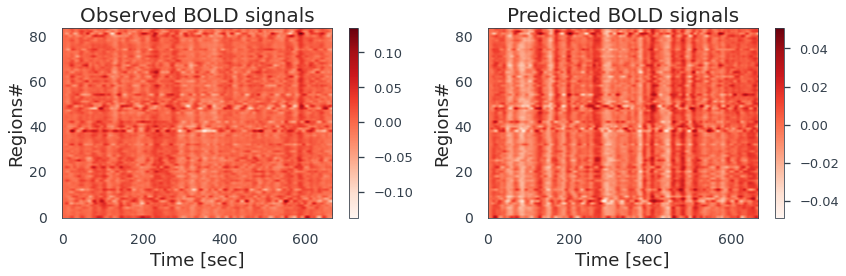

In [153]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.eps"), doi=800)
plt.show()

In [154]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

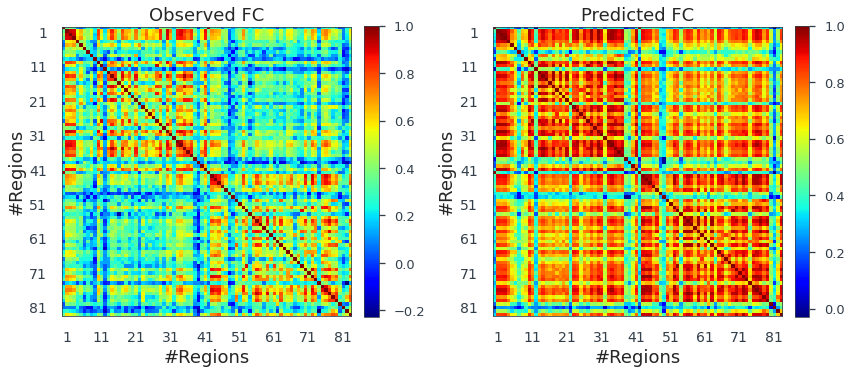

In [155]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.eps"), doi=800)
plt.show()

In [156]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

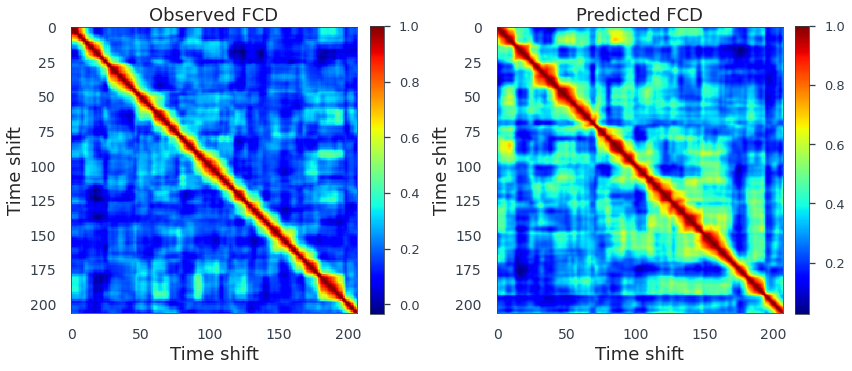

In [157]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


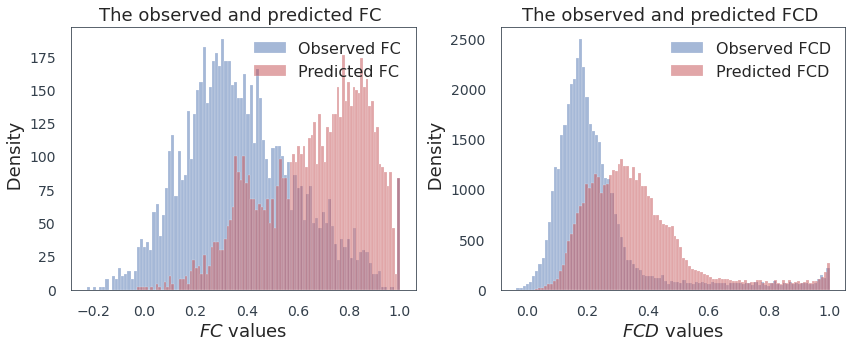

In [158]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.eps"), doi=800)
plt.show()

In [159]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(31.888095598309448, 55.96633662914495)

In [160]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(122.35912459505755, 186.13906835302777)

In [161]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [162]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(nan, nan)

In [163]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [164]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.12503244593034837

In [165]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.27838979845409073

In [166]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.44785175850078185, pvalue=0.0)

In [167]:
X_manifold_fit = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_fit.T).T
X_manifold_fit.shape

(2, 667)

In [168]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([5.99053734e-06, 2.54507302e-06]), array([0.00016668, 0.00016659]))

In [169]:
np.mean(X_manifold_fit, axis=1), np.var(X_manifold_fit, axis=1)

(array([-1.26272439e-05, -1.19869818e-05]), array([0.00016572, 0.00016639]))

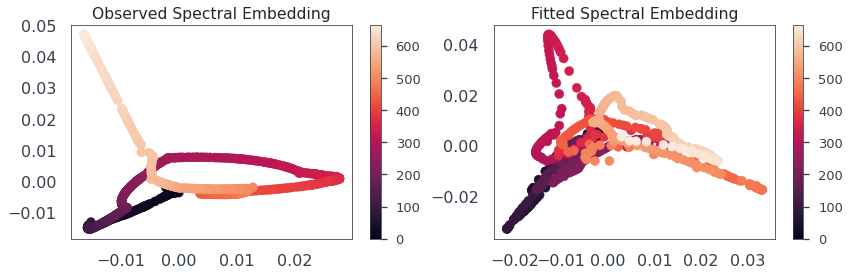

In [170]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Observed Spectral Embedding')

plt.subplot(122)
plt.scatter(X_manifold_fit[0], X_manifold_fit[1], c=np.r_[0:X_manifold_fit.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Fitted Spectral Embedding')

plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs2.eps"), doi=800)

plt.show()

### Observed data set III (hight G)

In [171]:
G_true=0.5

In [172]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.6263298988342285


In [173]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['Spectral_Embedding'])

In [174]:
obs_bold_features.max()

1.602802729391958

In [175]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (1437,))

In [176]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

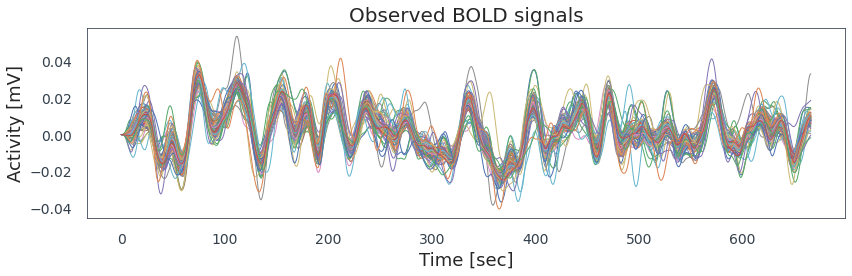

In [177]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.eps"), doi=800)
plt.show()

In [178]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [179]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

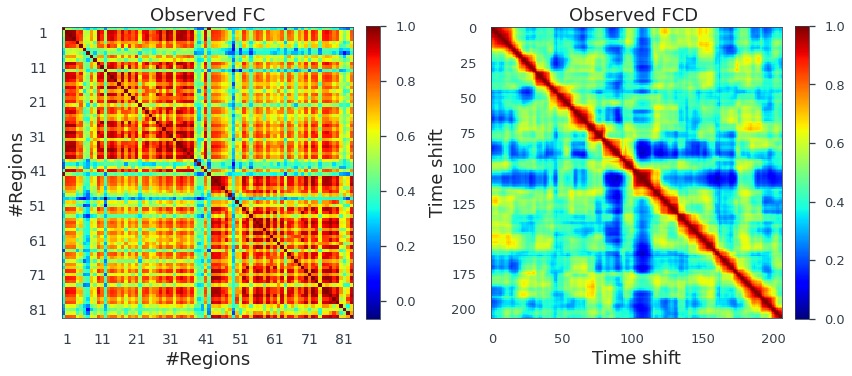

In [180]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs3.eps"), doi=800)
plt.show()

In [181]:
X_manifold_obs = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_obs.T).T
X_manifold_obs.shape

(2, 667)

In [182]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([-1.12766500e-05, -3.90398696e-05]), array([0.00016655, 0.00016587]))

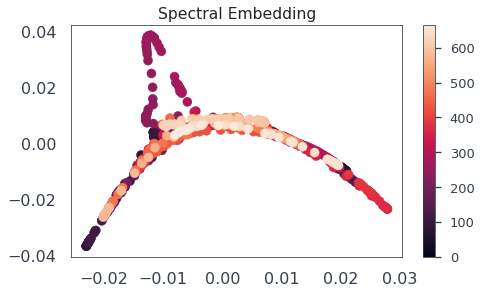

In [183]:
plt.figure(figsize=(7, 4))
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Spectral Embedding')
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs3.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [184]:
labels_params = [r'$G$']

In [185]:
num_samples=2000

In [186]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [187]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.06490421295166016


In [188]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs3.npy') , posterior_samples)

In [189]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [190]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.29173692],
       [0.48353617]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


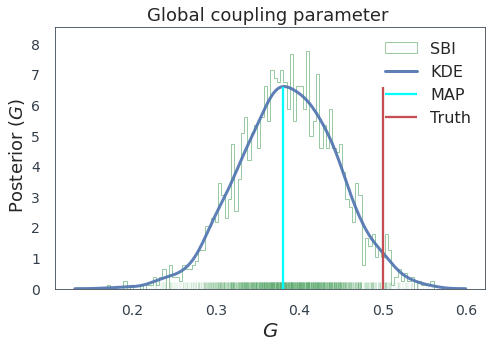

In [191]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.eps"), doi=800)
plt.show()

In [192]:
G_true, G_posterior.mean(), G_posterior.var()

(0.5, 0.38679853, 0.0034450297)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


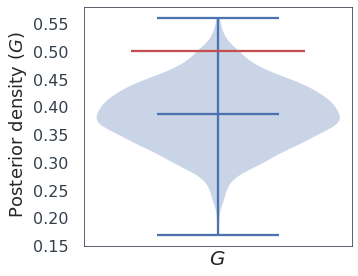

In [193]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.eps"), doi=800)
plt.show()

In [194]:
param_true=G_true
param_est_mu=G_posterior.mean()
param_est_std=G_posterior.std()
nodes=np.r_[0:num_params]

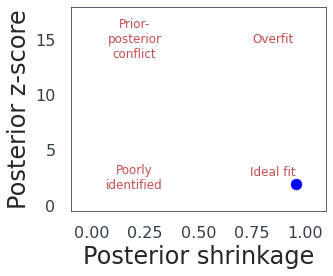

In [195]:
plt.figure(figsize=(5,4))
plot_zscore_shrinkage(nodes, param_true, param_est_mu, param_est_std, prior_std)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs3.eps"), doi=800)
plt.show()

In [196]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.29173692],
       [0.48353617]])

In [197]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [198]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [199]:
np.save(os.path.join(Res_dir, 'BOLD_obs3.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit3.npy') , BOLD_fit)

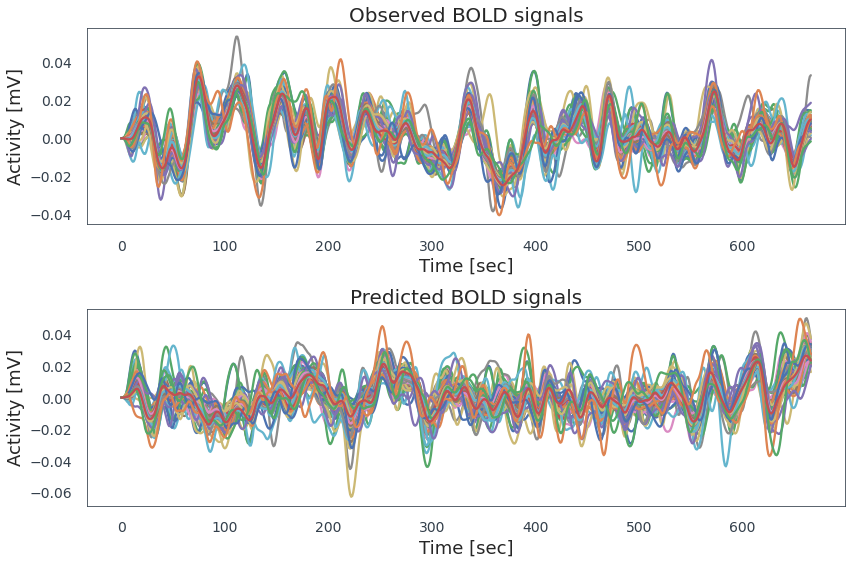

In [200]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.eps"), doi=800)
plt.show()

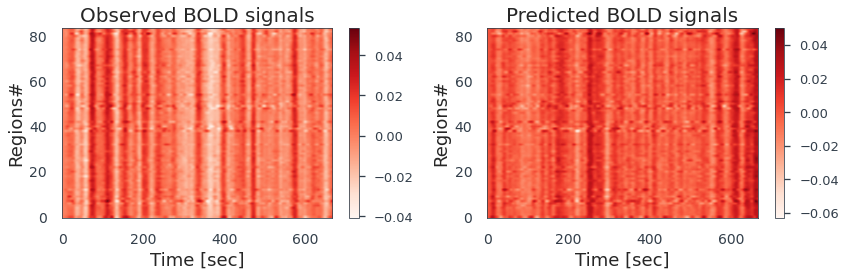

In [201]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.eps"), doi=800)
plt.show()

In [202]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

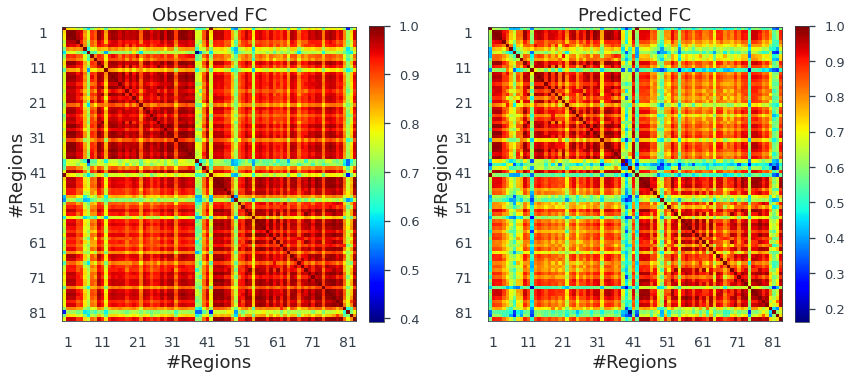

In [203]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.eps"), doi=800)
plt.show()

In [204]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

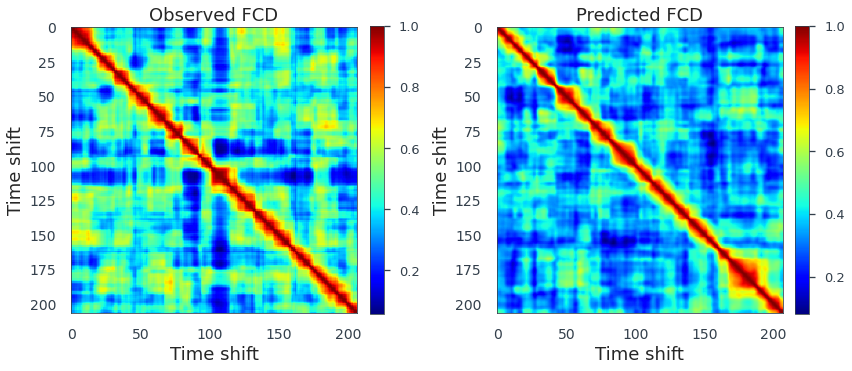

In [205]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


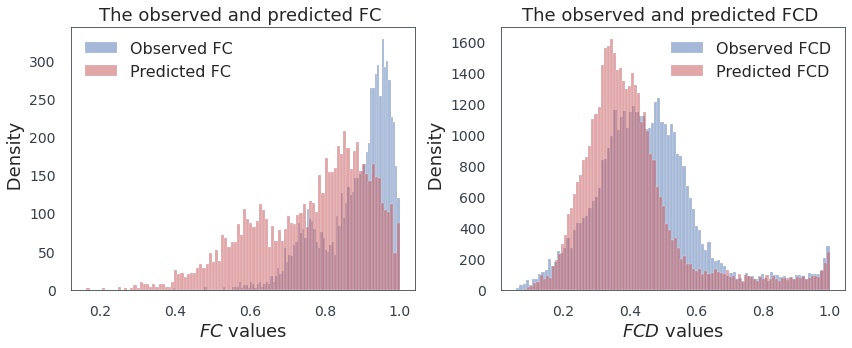

In [206]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.eps"), doi=800)
plt.show()

In [207]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(74.15566712125066, 64.24473041924035)

In [208]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(232.38861451175273, 207.65326430595502)

In [209]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [210]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(3339.452435176894, -922.1176371963694)

In [211]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

295.66367931089627

In [212]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.05033760432827145

In [213]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.12359944493580186

In [214]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.2144274078741628, pvalue=0.0)

In [215]:
X_manifold_fit = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_fit.T).T
X_manifold_fit.shape

(2, 667)

In [216]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([-1.12766500e-05, -3.90398696e-05]), array([0.00016655, 0.00016587]))

In [217]:
np.mean(X_manifold_fit, axis=1), np.var(X_manifold_fit, axis=1)

(array([2.51855670e-05, 2.05090746e-05]), array([0.00016713, 0.00016617]))

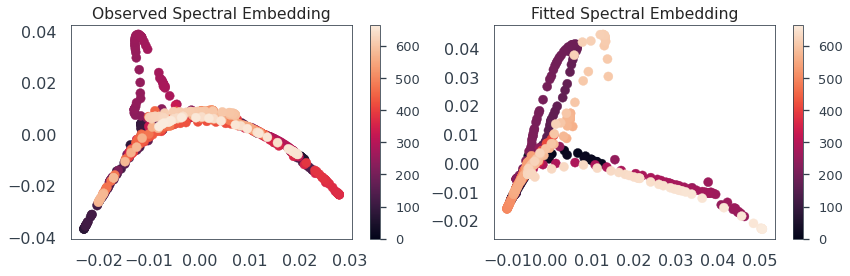

In [218]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Observed Spectral Embedding')

plt.subplot(122)
plt.scatter(X_manifold_fit[0], X_manifold_fit[1], c=np.r_[0:X_manifold_fit.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Fitted Spectral Embedding')

plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs3.eps"), doi=800)

plt.show()

### Observed data set IV (very hight G)

In [219]:
G_true=0.75

In [220]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.81727933883667


In [221]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['Spectral_Embedding'])

In [222]:
obs_bold_features.max()

2.660885842954378

In [223]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (1437,))

In [224]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

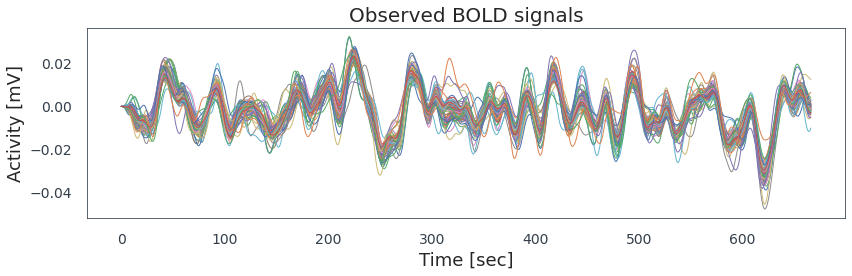

In [225]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs4.eps"), doi=800)
plt.show()

In [226]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [227]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

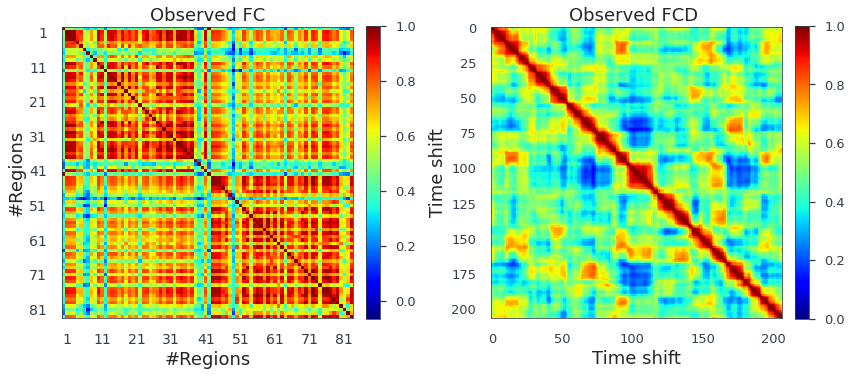

In [228]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs4.eps"), doi=800)
plt.show()

In [229]:
X_manifold_obs = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_obs.T).T
X_manifold_obs.shape

(2, 667)

In [230]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([1.30380411e-05, 4.68271767e-05]), array([0.00016727, 0.00016753]))

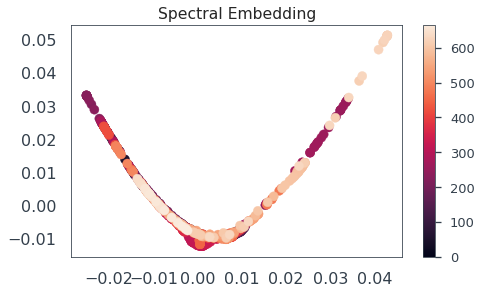

In [231]:
plt.figure(figsize=(7, 4))
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Spectral Embedding')
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_SpectralEmbedding_obs4.eps"), doi=800)
plt.show()

### Posterior of G for  data set IV

In [232]:
labels_params = [r'$G$']

In [233]:
num_samples=2000

In [234]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [235]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.04442334175109863


In [236]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs4.npy') , posterior_samples)

In [237]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [238]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.44885789],
       [0.92615506]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


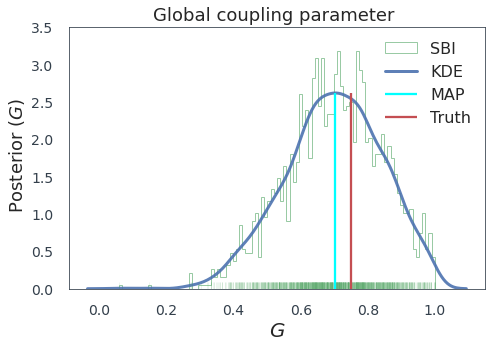

In [239]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.eps"), doi=800)
plt.show()

In [240]:
G_true, G_posterior.mean(), G_posterior.var()

(0.75, 0.69811004, 0.020634973)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


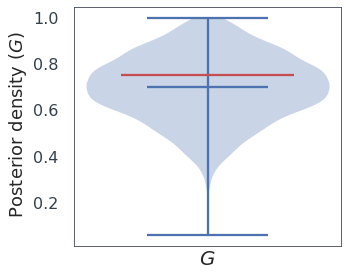

In [241]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.eps"), doi=800)
plt.show()

In [242]:
param_true=G_true
param_est_mu=G_posterior.mean()
param_est_std=G_posterior.std()
nodes=np.r_[0:num_params]

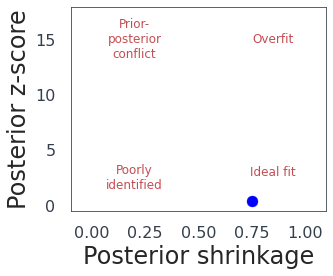

In [243]:
plt.figure(figsize=(5,4))
plot_zscore_shrinkage(nodes, param_true, param_est_mu, param_est_std, prior_std)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_zscore_shrinkage_obs4.eps"), doi=800)
plt.show()

In [244]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.44885789],
       [0.92615506]])

In [245]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [246]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [247]:
np.save(os.path.join(Res_dir, 'BOLD_obs4.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit4.npy') , BOLD_fit)

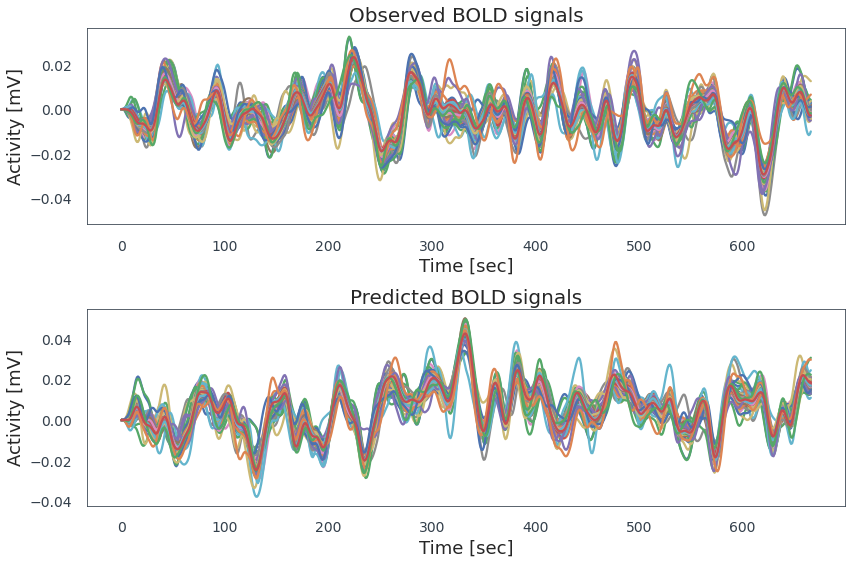

In [248]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.eps"), doi=800)
plt.show()

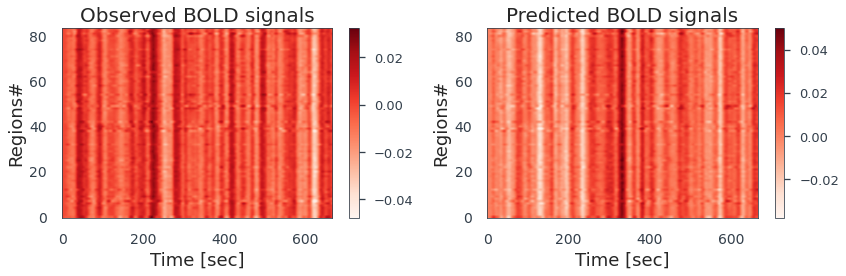

In [249]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.eps"), doi=800)
plt.show()

In [250]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

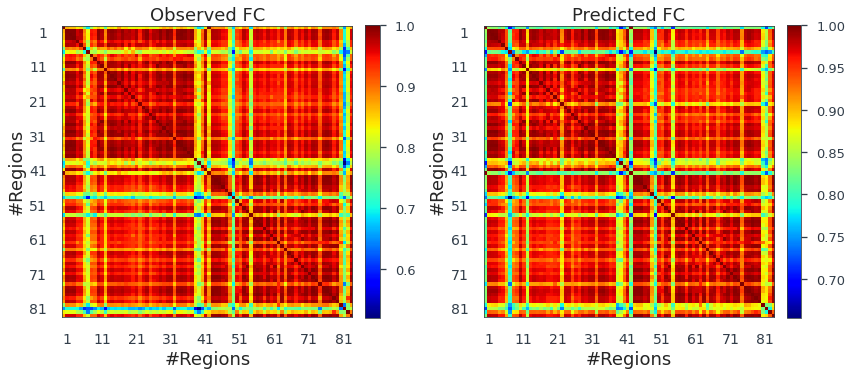

In [251]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.eps"), doi=800)
plt.show()

In [252]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

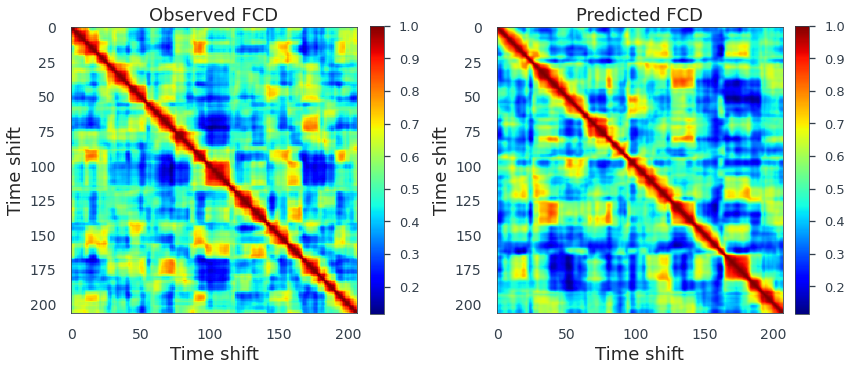

In [253]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


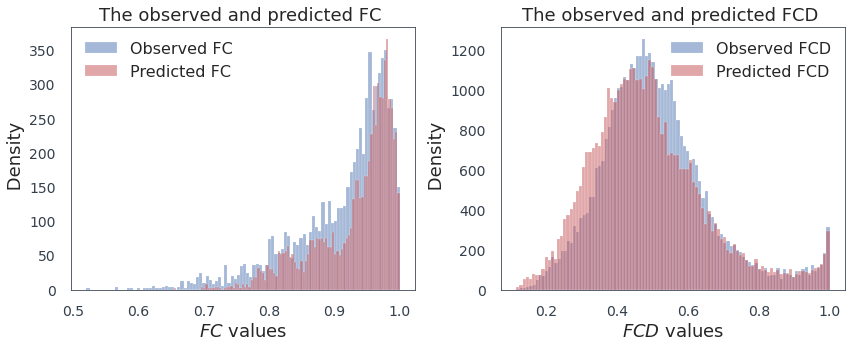

In [254]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.eps"), doi=800)
plt.show()

In [255]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(76.66402774388587, 78.24783291542356)

In [256]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(260.37158411138864, 249.86261040056309)

In [257]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [258]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(2410.4067795758237, 533.0166422382098)

In [259]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

359.91492265110236

In [260]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.020861694874706117

In [261]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.04978922628294454

In [262]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.08130878200191372, pvalue=1.1840208078445245e-123)

In [263]:
X_manifold_fit = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors).fit_transform(BOLD_fit.T).T
X_manifold_fit.shape

(2, 667)

In [264]:
np.mean(X_manifold_obs, axis=1), np.var(X_manifold_obs, axis=1)

(array([1.30380411e-05, 4.68271767e-05]), array([0.00016727, 0.00016753]))

In [265]:
np.mean(X_manifold_fit, axis=1), np.var(X_manifold_fit, axis=1)

(array([2.80222024e-06, 6.02509953e-05]), array([0.00016704, 0.00016787]))

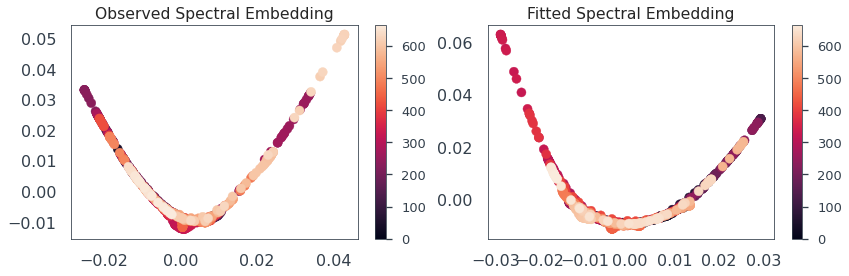

In [266]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(X_manifold_obs[0], X_manifold_obs[1], c=np.r_[0:X_manifold_obs.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Observed Spectral Embedding')

plt.subplot(122)
plt.scatter(X_manifold_fit[0], X_manifold_fit[1], c=np.r_[0:X_manifold_fit.shape[1]])
plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.title('Fitted Spectral Embedding')

plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_SpectralEmbedding_obs5.eps"), doi=800)

plt.show()